In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [2]:
torch.manual_seed(975)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
batch_size = 64
epochs = 10
log_interval = 100
learning_rate = 1e-3
latent_dim = 20
num_classes = 10
input_dim = 784

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
    ])

train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=batch_size, shuffle=True)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        # 인코더
        self.fc1 = nn.Linear(input_dim + num_classes, 512)
        # 잠재공간
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)
        # 디코더
        self.fc3 = nn.Linear(latent_dim + num_classes, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x, labels):
        combined = torch.cat([x, labels], dim=1)
        h1 = F.relu(self.fc1(combined))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        combined = torch.cat([z, labels], dim=1)
        h3 = F.relu(self.fc3(combined))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, labels):
        mu, logvar = self.encode(x.view(-1, 784), labels)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels), mu, logvar


In [6]:
def loss_function(recon_x, x, mu, logvar):
    # x를 flatten하여 recon_x와 동일한 차원으로 만듦
    x_flat = x.view(-1, 784)
    BCE = F.binary_cross_entropy(recon_x, x_flat, reduction='sum')

    # KL 발산
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [7]:
model = CVAE()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        labels = torch.zeros(target.size(0), num_classes).to(device).scatter_(1, target.unsqueeze(1), 1)
        recon_batch, mu, logvar = model(data, labels)

        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    average_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average loss: {average_loss:.4f}')

In [9]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)

KeyboardInterrupt: 

In [ ]:
def get_class_latent_stats(model, data_loader, class_label):
    model.eval()
    with torch.no_grad():
        mus, logvars = [], []
        for data, target in data_loader:
            data = data[target == class_label].to(device)
            target = target[target == class_label].to(device)
            if len(data) > 0:
                label_tensor = torch.tensor([class_label] * len(data)).to(device)
                labels = torch.zeros(len(data), num_classes).to(device).scatter_(1, label_tensor.unsqueeze(1), 1)
                mu, logvar = model.encode(data.view(-1, 784), labels)
                mus.append(mu)
                logvars.append(logvar)

        class_mu = torch.cat(mus, dim=0).mean(dim=0)
        class_logvar = torch.cat(logvars, dim=0).mean(dim=0)

        return class_mu, class_logvar

In [ ]:
def visualize_class_samples(model, class_label, num_samples):
    model.eval()
    with torch.no_grad():
        class_mu, class_logvar = get_class_latent_stats(model, train_loader, class_label)
        class_std = 1.5 * np.exp(0.5 * class_logvar.cpu().numpy())

        eps = torch.randn(num_samples, latent_dim).to(device)
        z = eps * torch.from_numpy(class_std).float().to(device) + class_mu

        recon_images = model.decode(z, torch.eye(num_classes)[class_label].to(device).repeat(num_samples, 1)).cpu()

        plt.figure(figsize=(10, 10))
        for i in range(num_samples):
            plt.subplot(5, 5, i + 1)
            plt.imshow(recon_images[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

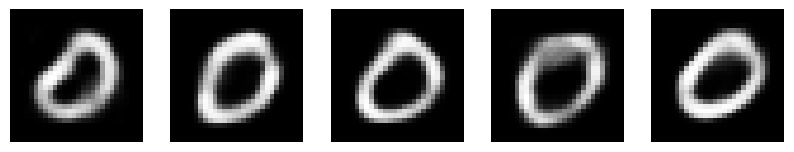

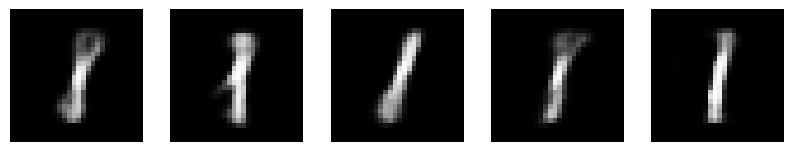

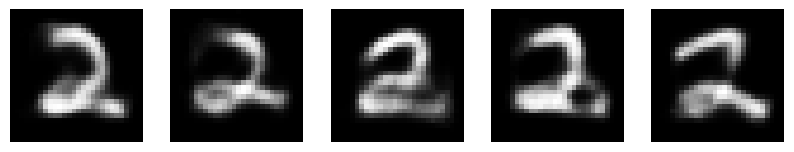

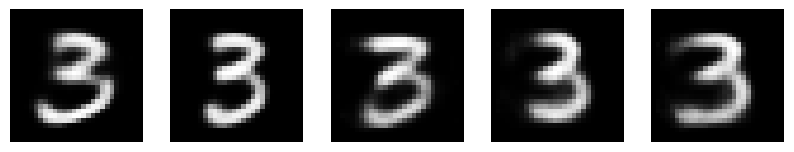

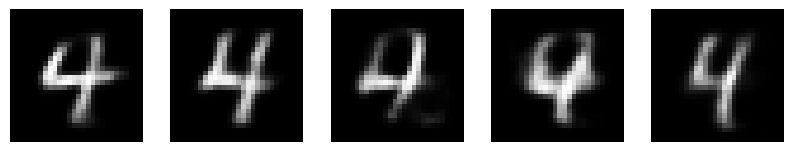

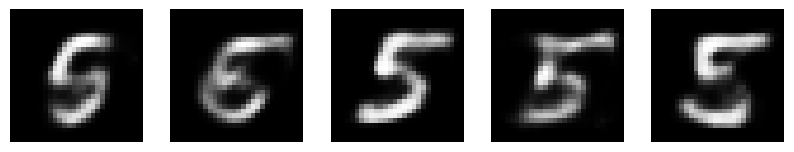

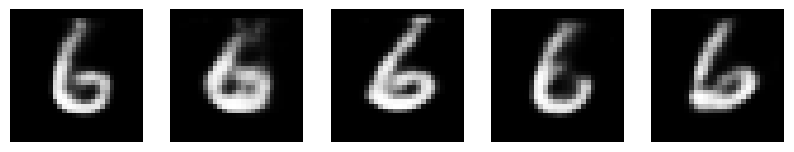

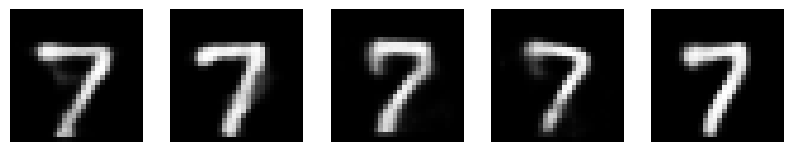

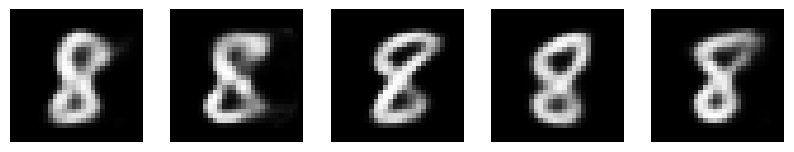

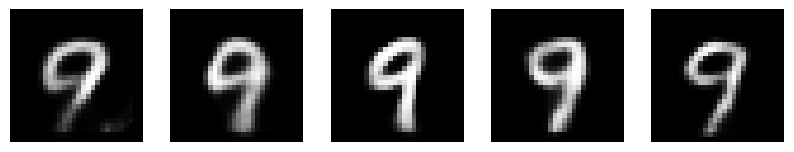

In [ ]:
for i in range(10):
    visualize_class_samples(model, class_label=i, num_samples=5)